## 3.3 ホワイトバランス補正

### この節について

この節では、ホワイトバランス補正を行い画像の色を修正します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_toc.ipynb)から参照するか、以下のリンクを使ってアクセスしてください。

https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_3_3.ipynb

### 準備

まず3.1節で行ったライブラリーのインストールと、モジュールのインポート、画像のダウンロード、及びRAW画像の読み込みを行います。
内容については3.1節を参照ください

In [0]:
# rawpyとimageioのインストール
!pip install rawpy
!pip install imageio

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt

# 前節までに作成したモジュールのダウンロード
!if [ ! -f raw_process.py ]; then wget https://raw.githubusercontent.com/moizumi99/camera_raw_processing/master/raw_process.py; fi

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'

from raw_process import simple_demosaic

# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

In [0]:
# もし日本語が文字化けしている場合以下の３行の#を外して実行しRuntime->Restart Runtimeで再実行
# import matplotlib
# target_dir = matplotlib.get_cachedir()
# ! rm {target_dir}/*.json

### ホワイトバランス補正とは

ホワイトバランス補正とは、センサーの色ごとの感度や、光のスペクトラムなどの影響を除去して、本来の白を白として再現するための処理です。 
そのためには各色の画素に、別途計算したゲイン値をかけてあげます。

実際のカメラではホワイトバランスの推定はAWB（オートホワイトバランス）と呼ばれる複雑な処理によって行いますが、今回はカメラが撮影時に計算したゲイン値をRAWファイルから抽出して使います。

### ホワイトバランス補正処理

ますはどんなホワイトバランス値かみてみましょう。RAWファイルの中に記録されたゲインを見てみましょう。

rawpyのアトリビュートcamera_whitebalanceを使います

In [3]:
wb = raw.camera_whitebalance
print(wb)

[1.128000020980835, 1.0, 2.5460000038146973, 1.0]


これは、赤、緑（赤と同じ行）、青、緑（青と同じ行）のゲインがそれぞれ、1.128、1.0、2.546、1.0ということをあらわしています。

緑のゲインは1.0倍なので、赤、青をそれぞれ、1.128倍、2.546倍にしてやればカラーバランスが取れることがわかります。

処理してみましょう。

In [0]:
# 元のRAWデータをコピーします。
wb_img = raw_array.copy()
# RAWデータのベイヤーパターン。
bayer_pattern = raw.raw_pattern
for y in range(0, h):
    for x in range(0, w):
        # cは画素に対応する色チャンネル
        c = bayer_pattern[y % 2, x % 2]
        # 各画素に画素の色に対応するゲインをかけ合わせる
        wb_img[y, x] *= wb[c]

これでホワイトバランスがそろったかみてみましょう。
3.2で使用した簡易デモザイクを使って表示します。

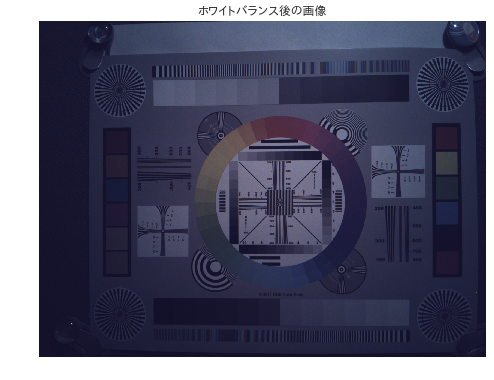

In [5]:
# 簡易デモザイク。
# 詳細は3.2節を参照
dms_img = np.zeros((h//2, w//2, 3))
bayer_pattern[bayer_pattern==3] = 1
dms_img[:, :, bayer_pattern[0, 0]] = wb_img[0::2, 0::2]
dms_img[:, :, bayer_pattern[0, 1]] += wb_img[0::2, 1::2]
dms_img[:, :, bayer_pattern[1, 0]] += wb_img[1::2, 0::2]
dms_img[:, :, bayer_pattern[1, 1]] += wb_img[1::2, 1::2]
dms_img[:, :, 1] /= 2

# 画像を0と1の間でノーマライズ
dms_img /= 1024
dms_img[dms_img < 0] = 0
dms_img[dms_img > 1] = 1.0
# 表示
plt.figure(figsize=(8, 8))
plt.imshow(dms_img)
plt.axis('off')
plt.title(u"ホワイトバランス後の画像")
plt.show()

これでだいぶ色がよくなりました。

まだ青みが強い画像になっています。ブラックレベルの補正がされていないためだと思われます。ブラックレベル補正は次の節で扱います。

### 処理の高速化

先程扱ったホワイトバランスの処理は、コードの読みやすさを優先したものなので低速です。

numpyの機能を利用して高速化した関数は次のようになります。

In [0]:
def white_balance(raw_array, wb_gain, raw_colors):
    """
    ホワイトバランス補正処理を行う。

    Parameters
    ----------
    raw_array: numpy array
        入力BayerRAW画像データ。
    wb_gain: float[4]
        ホワイトバランスゲイン。
    raw_colors: int[h, w]
        RAW画像のカラーチャンネルマトリクス。

    Returns
    -------
    wb_img: numpy array
        出力RAW画像。
    """
    norm = wb_gain[1]
    gain_matrix = np.zeros(raw_array.shape)
    for color in (0, 1, 2, 3):
        gain_matrix[raw_colors == color] = wb_gain[color] / norm
    wb_img = raw_array * gain_matrix
    return wb_img

この関数を使ってホワイトバランス処理を行うにはこのように書きます。

In [0]:
wb_img = white_balance(raw_array, raw.camera_whitebalance, raw.raw_colors)

簡易デモザイク処理を行って確認しましょう。

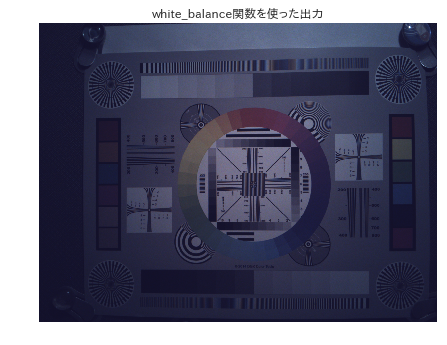

In [8]:
# 簡易デモザイク。
dms_img = simple_demosaic(wb_img, raw.raw_pattern)

# 画像を0と1の間でノーマライズ
dms_img /= 1024
dms_img[dms_img < 0] = 0
dms_img[dms_img > 1] = 1.0
# 表示
plt.imshow(dms_img)
plt.axis('off')
plt.title(u"white_balance関数を使った出力")
plt.show()

同様の画像が出力されたようです。

この`white_balance()`関数は`raw_process.py`モジュールの一部としてgithubからダウンロードできます。 使用する場合は、

`!wget https://raw.githubusercontent.com/moizumi99/camera_raw_processing/master/raw_process.py`

としてダウンロードした後、

`from raw_process import white_balance`

としてインポートしてください。

### この節のまとめ

この節ではホワイトバランスの調整を行いました。次は[ブラックレベル補正](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_3_4.ipynb)を行い、色再現を向上します。